# Comprehensive Sales Analysis - Customer Data Insights
### Advanced Statistical Analysis, Segmentation, and Forecasting

### 1.0 Initialising libraries and modules

In [1]:
# Initialising libraries and modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, ttest_ind, chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== COMPREHENSIVE SALES ANALYSIS FRAMEWORK ===")
print("Libraries loaded successfully!\n")


=== COMPREHENSIVE SALES ANALYSIS FRAMEWORK ===
Libraries loaded successfully!



### 1.1 Loading the Data 

In [2]:
# Load the data
try:
    cl_sales_data = pd.read_csv('cleaned_sales_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: cleaned_sales_data.csv not found. Please ensure the file is in the correct directory.")
    exit(1)
df = pd.DataFrame(cl_sales_data)

Data loaded successfully!


In [3]:
# Create derived metrics
df['Marketing_ROI'] = df['Total_Spend'] / df['Marketing_Spend']
df['Spend_per_Purchase'] = df['Total_Spend'] / df['Purchase_Frequency']
df['Churned_Binary'] = df['Churned'].map({'Yes': 1, 'No': 0})

print(f"\nDerived metrics created: Marketing_ROI, Spend_per_Purchase, Churned_Binary")



Derived metrics created: Marketing_ROI, Spend_per_Purchase, Churned_Binary


### 1.2 Exploratory Data Analysis


1.2 EXPLORATORY DATA ANALYSIS
------------------------------
Descriptive Statistics:
       Customer_ID  Total_Spend  Purchase_Frequency  Marketing_Spend  \
count    16.000000    16.000000        1.600000e+01     1.600000e+01   
mean    108.500000     0.000000       -1.387779e-17     1.387779e-17   
std       4.760952     1.032796        1.032796e+00     1.032796e+00   
min     101.000000    -1.211354       -1.441153e+00    -1.439105e+00   
25%     104.750000    -0.859969       -8.807048e-01    -7.995027e-01   
50%     108.500000    -0.175693        0.000000e+00    -5.330018e-02   
75%     112.250000     0.693523        8.006408e-01     7.462025e-01   
max     116.000000     2.117558        1.761410e+00     1.758906e+00   

       Seasonality_Index    Churned  Marketing_ROI  Spend_per_Purchase  \
count       1.600000e+01  16.000000      16.000000           16.000000   
mean        3.330669e-16   0.500000       1.064419            1.267426   
std         1.032796e+00   0.516398       0

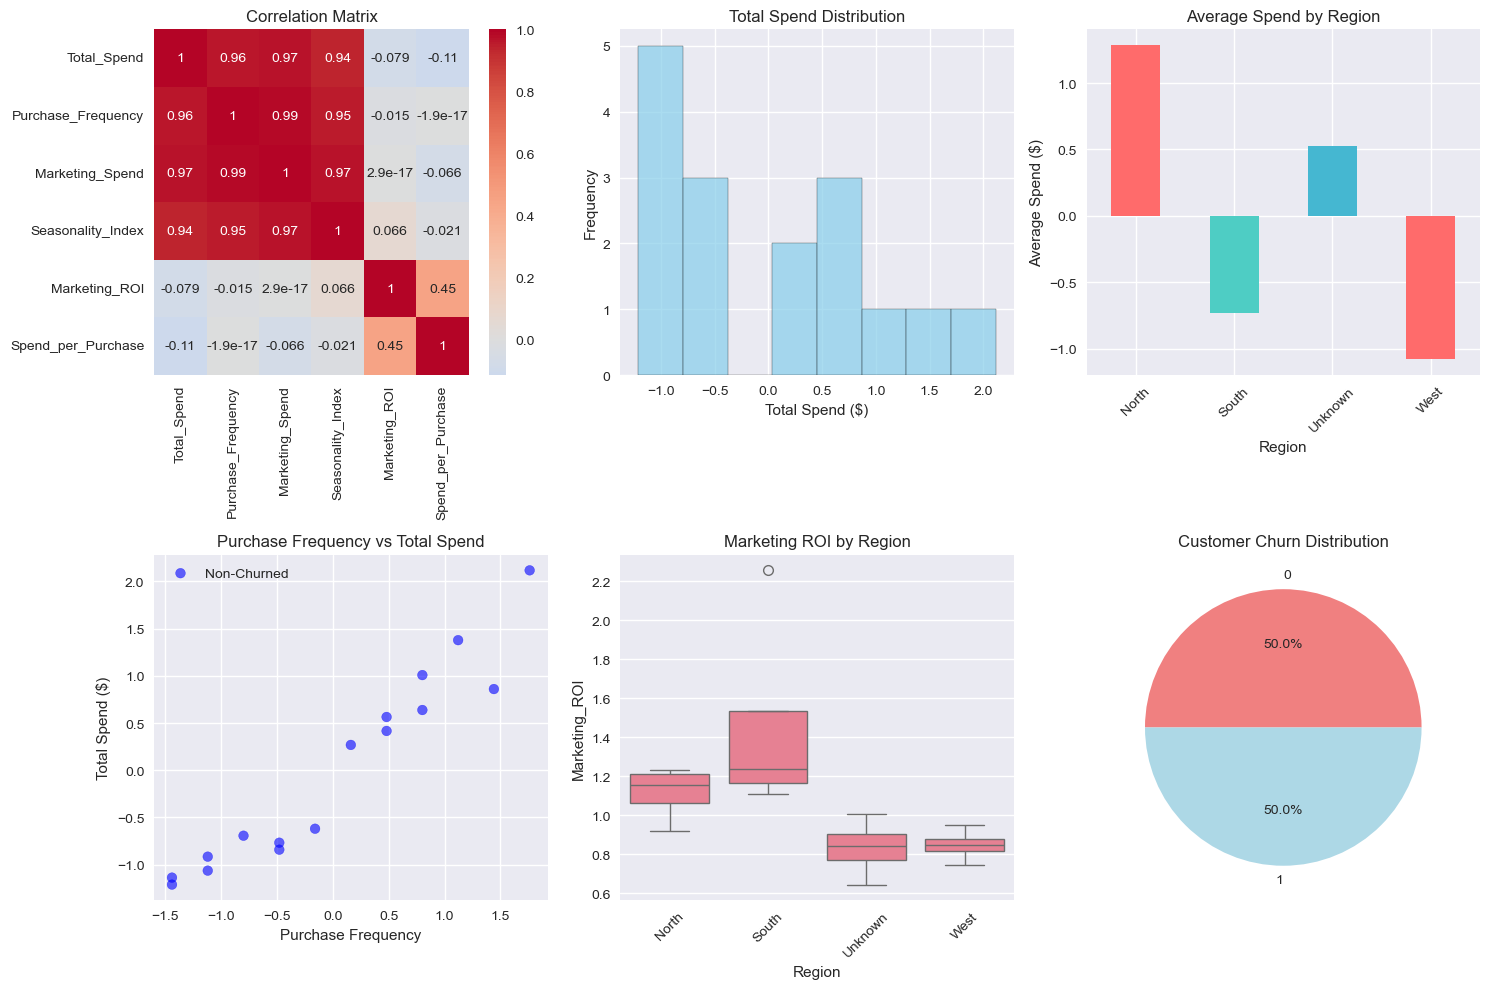

In [ ]:
# Exploratory Data Analysis
print("\n1.2 EXPLORATORY DATA ANALYSIS")
print("-" * 30)

# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

# Correlation analysis
numerical_cols = ['Total_Spend', 'Purchase_Frequency', 'Marketing_Spend', 'Seasonality_Index', 'Marketing_ROI', 'Spend_per_Purchase']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(15, 10))

# Subplot 1: Correlation Heatmap
plt.subplot(2, 3, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

# Subplot 2: Total Spend Distribution
plt.subplot(2, 3, 2)
plt.hist(df['Total_Spend'], bins=8, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Total Spend Distribution')
plt.xlabel('Total Spend ($)')
plt.ylabel('Frequency')

# Subplot 3: Spend by Region
plt.subplot(2, 3, 3)
# Create a 'Region' column based on boolean columns
def get_region(row):
	if row['Region_North']:
		return 'North'
	elif row['Region_South']:
		return 'South'
	elif row['Region_West']:
		return 'West'
	else:
		return 'Unknown'
df['Region'] = df.apply(get_region, axis=1)
region_spend = df.groupby('Region')['Total_Spend'].mean()
region_spend.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Average Spend by Region')
plt.xlabel('Region')
plt.ylabel('Average Spend ($)')
plt.xticks(rotation=45)

# Subplot 4: Purchase Frequency vs Total Spend
plt.subplot(2, 3, 4)
colors = ['red' if x == 'Yes' else 'blue' for x in df['Churned']]
plt.scatter(df['Purchase_Frequency'], df['Total_Spend'], c=colors, alpha=0.6)
plt.title('Purchase Frequency vs Total Spend')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spend ($)')
plt.legend(['Non-Churned', 'Churned'])

# Subplot 5: Marketing ROI by Region
plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='Region', y='Marketing_ROI')
plt.title('Marketing ROI by Region')
plt.xticks(rotation=45)

# Subplot 6: Churn Analysis
plt.subplot(2, 3, 6)
churn_counts = df['Churned'].value_counts()
plt.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title('Customer Churn Distribution')

plt.tight_layout()
plt.show()

## PHASE 2: STATISTICAL ANALYSIS & HYPOTHESIS TESTING

In [6]:
print("\n" + "="*50)
print("PHASE 2: STATISTICAL ANALYSIS & HYPOTHESIS TESTING")
print("=" * 50)

# 2.1 ANOVA Testing
print("2.1 ANOVA TESTING")
print("-" * 20)

# One-way ANOVA: Total Spend by Region
regions = df['Region'].unique()
region_groups = [df[df['Region'] == region]['Total_Spend'].values for region in regions]
f_stat, p_value = f_oneway(*region_groups)

print(f"One-way ANOVA: Total Spend by Region")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

# Two-way ANOVA using statsmodels
model = ols('Total_Spend ~ C(Region) + C(Churned) + C(Region):C(Churned)', data=df).fit()
anova_results = anova_lm(model, typ=2)
print(f"\nTwo-way ANOVA Results (Total Spend ~ Region + Churn + Interaction):")
print(anova_results)

# T-test: Churned vs Non-churned customers
churned_spend = df[df['Churned'] == 'Yes']['Total_Spend']
non_churned_spend = df[df['Churned'] == 'No']['Total_Spend']
t_stat, t_p_value = ttest_ind(churned_spend, non_churned_spend)

print(f"\nIndependent t-test: Churned vs Non-churned Total Spend")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {t_p_value:.4f}")
print(f"Significant at α=0.05: {'Yes' if t_p_value < 0.05 else 'No'}")

# Effect size calculation (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1-1)*group1.var() + (n2-1)*group2.var()) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

cohens_d_value = cohens_d(non_churned_spend, churned_spend)
print(f"Cohen's d (effect size): {cohens_d_value:.4f}")



PHASE 2: STATISTICAL ANALYSIS & HYPOTHESIS TESTING
2.1 ANOVA TESTING
--------------------
One-way ANOVA: Total Spend by Region
F-statistic: 39.7196
P-value: 0.0000
Significant at α=0.05: Yes

Two-way ANOVA Results (Total Spend ~ Region + Churn + Interaction):
                         sum_sq    df          F    PR(>F)
C(Region)              2.222488   3.0   6.072897  0.015067
C(Churned)                  NaN   1.0        NaN       NaN
C(Region):C(Churned)  19.581702   3.0  53.506542  0.000001
Residual               1.463873  12.0        NaN       NaN

Independent t-test: Churned vs Non-churned Total Spend
T-statistic: nan
P-value: nan
Significant at α=0.05: No
Cohen's d (effect size): nan


## PHASE 3: CUSTOMER SEGMENTATION ANALYSIS



PHASE 3: CUSTOMER SEGMENTATION ANALYSIS
3.1 RFM-STYLE SEGMENTATION
------------------------------
Cluster Summary:
         Total_Spend  Purchase_Frequency  Marketing_ROI
Cluster                                                
0          -0.915451           -0.937893       0.996312
1           0.906204            0.880705       0.975145
2          -0.841475           -0.480384       2.255353

Customer Segment Distribution:
Customer_Segment
Premium Customers    8
Value Seekers        7
Frequent Buyers      1
Name: count, dtype: int64

3.2 GEOGRAPHIC AND BEHAVIORAL ANALYSIS
----------------------------------------
Regional Performance Metrics:
        Total_Spend             Purchase_Frequency Marketing_ROI  \
               mean   sum   std               mean          mean   
Region                                                             
North          1.29  5.14  0.63               1.12          1.12   
South         -0.73 -2.92  0.10              -0.48          1.46   
Unknown  

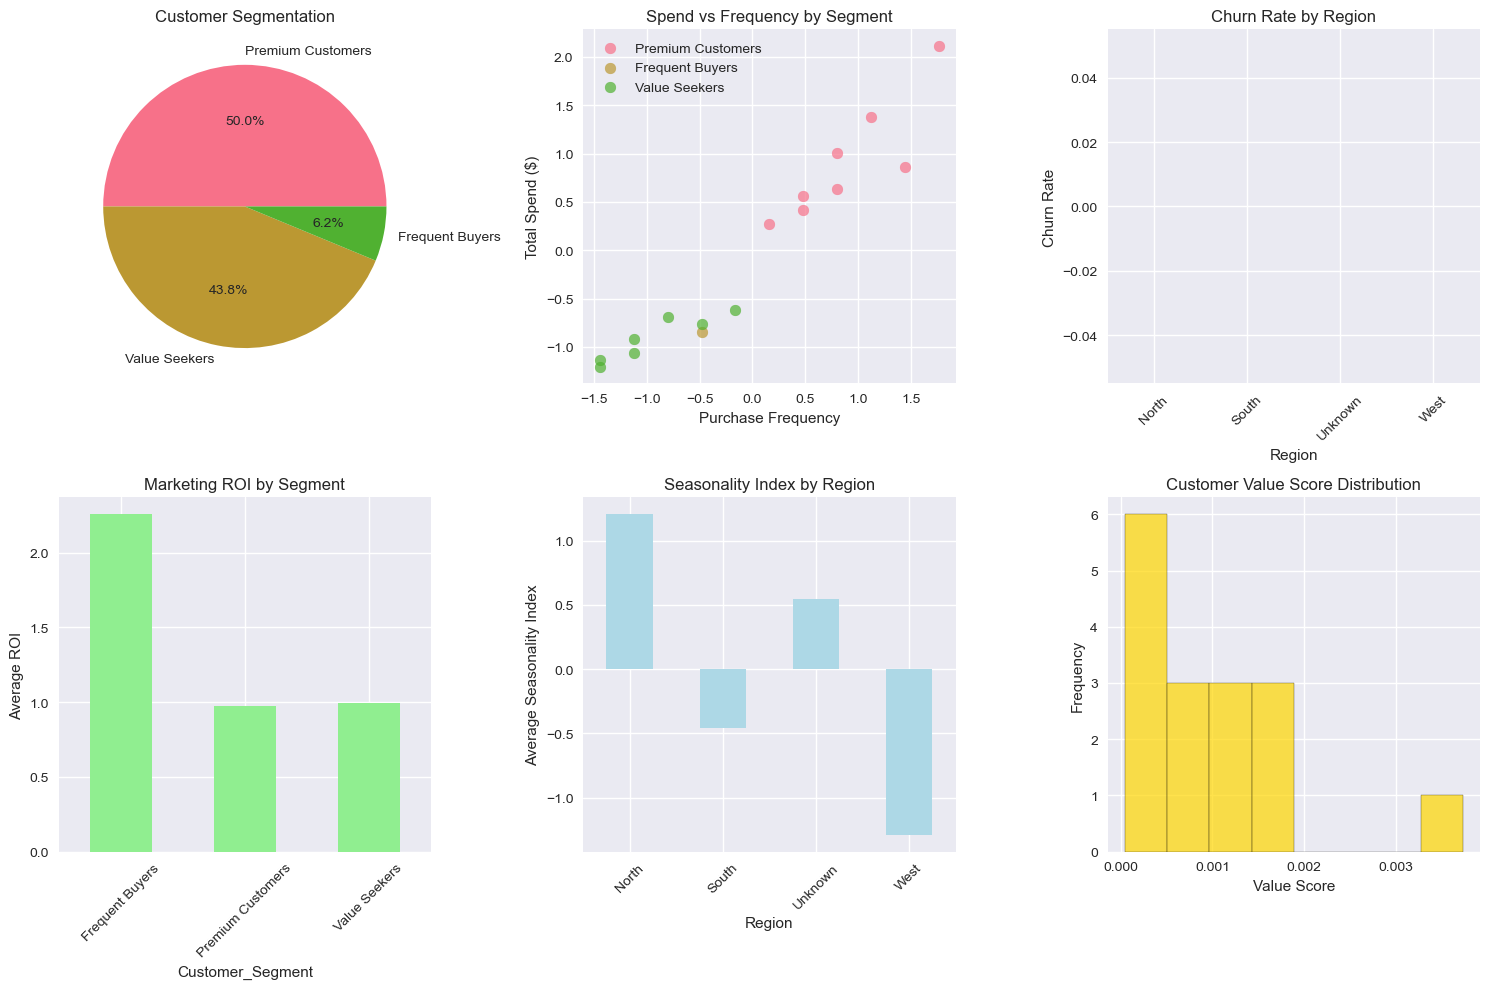

In [7]:
print("\n" + "="*50)
print("PHASE 3: CUSTOMER SEGMENTATION ANALYSIS")
print("=" * 50)

# 3.1 RFM-Style Segmentation
print("3.1 RFM-STYLE SEGMENTATION")
print("-" * 30)

# Create value tiers
df['Spend_Quartile'] = pd.qcut(df['Total_Spend'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
df['Frequency_Quartile'] = pd.qcut(df['Purchase_Frequency'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Customer Value Score (composite metric)
scaler = StandardScaler()
features_for_scoring = ['Total_Spend', 'Purchase_Frequency', 'Marketing_ROI', 'Seasonality_Index']
scaled_features = scaler.fit_transform(df[features_for_scoring])

# K-means clustering for customer segmentation
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Label clusters based on characteristics
cluster_summary = df.groupby('Cluster')[['Total_Spend', 'Purchase_Frequency', 'Marketing_ROI']].mean()
print("Cluster Summary:")
print(cluster_summary)

# Assign meaningful labels to clusters
cluster_labels = {0: 'Value Seekers', 1: 'Premium Customers', 2: 'Frequent Buyers'}
df['Customer_Segment'] = df['Cluster'].map(cluster_labels)

print(f"\nCustomer Segment Distribution:")
print(df['Customer_Segment'].value_counts())

# 3.2 Geographic and Behavioral Analysis
print("\n3.2 GEOGRAPHIC AND BEHAVIORAL ANALYSIS")
print("-" * 40)

# Regional performance metrics
regional_metrics = df.groupby('Region').agg({
    'Total_Spend': ['mean', 'sum', 'std'],
    'Purchase_Frequency': 'mean',
    'Marketing_ROI': 'mean',
    'Churned_Binary': 'mean'
}).round(2)

print("Regional Performance Metrics:")
print(regional_metrics)

# Visualization of segmentation results
plt.figure(figsize=(15, 10))

# Customer segments visualization
plt.subplot(2, 3, 1)
segment_counts = df['Customer_Segment'].value_counts()
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
plt.title('Customer Segmentation')

# Spend vs Frequency by Segment
plt.subplot(2, 3, 2)
for segment in df['Customer_Segment'].unique():
    segment_data = df[df['Customer_Segment'] == segment]
    plt.scatter(segment_data['Purchase_Frequency'], segment_data['Total_Spend'], 
               label=segment, alpha=0.7, s=60)
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spend ($)')
plt.title('Spend vs Frequency by Segment')
plt.legend()

# Regional churn rates
plt.subplot(2, 3, 3)
churn_by_region = df.groupby('Region')['Churned_Binary'].mean()
churn_by_region.plot(kind='bar', color='coral')
plt.title('Churn Rate by Region')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

# Marketing efficiency by segment
plt.subplot(2, 3, 4)
roi_by_segment = df.groupby('Customer_Segment')['Marketing_ROI'].mean()
roi_by_segment.plot(kind='bar', color='lightgreen')
plt.title('Marketing ROI by Segment')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)

# Seasonality impact by region
plt.subplot(2, 3, 5)
seasonality_by_region = df.groupby('Region')['Seasonality_Index'].mean()
seasonality_by_region.plot(kind='bar', color='lightblue')
plt.title('Seasonality Index by Region')
plt.ylabel('Average Seasonality Index')
plt.xticks(rotation=45)

# Customer value distribution
plt.subplot(2, 3, 6)
df['Customer_Value_Score'] = (df['Total_Spend'] * df['Purchase_Frequency']) / 1000
plt.hist(df['Customer_Value_Score'], bins=8, alpha=0.7, color='gold', edgecolor='black')
plt.title('Customer Value Score Distribution')
plt.xlabel('Value Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
